# 1. Import the libraries 

In [51]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# !pip install joblib 
import joblib 
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# 2. Load the dataset and add headers

In [52]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('data.csv',names=columns)

In [53]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


#### Dropping the timestamp column

In [54]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [55]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [56]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  3


In [57]:
#Check the datatypes
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [58]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:]

* Since the data is very big. Consider electronics_df1 named dataframe with  first 50000 rows and all columns from 0 of dataset.

In [59]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  object 
 1   productId  50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [60]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count    50000.00000
mean         4.03524
std          1.35555
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: ratings, dtype: float64

In [61]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


* Rating are on the scale 1 to 5.

# Handling Missing values

In [62]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


* There are no missing records in the dataset.

## Ratings

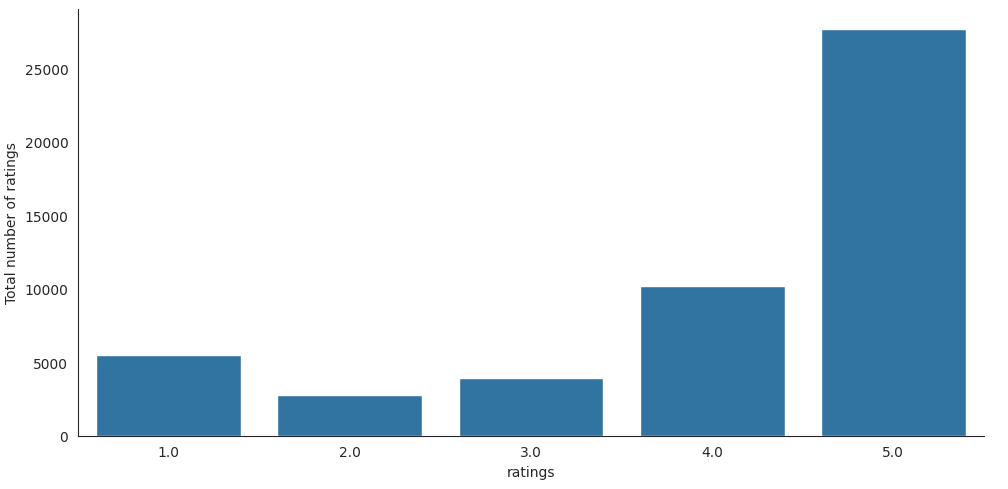

In [63]:
# Check the distribution of the rating
with sns.axes_style('white'):
    # g = sns.factorplot("ratings", data=electronics_df1, aspect=2.0,kind='count')
    g = sns.catplot(x="ratings", data=electronics_df1, aspect=2.0, kind='count')

    g.set_ylabels("Total number of ratings") 

* We can see that more number of users have given the rating of 5.

## Users and products

In [64]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  46554
Number of unique product in Raw data =  3446


# 3. Taking the subset of dataset to make it less sparse/ denser.

In [65]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A231WM2Z2JL0U3    37
AY8Q1X7G96HV5     31
ALUNVOQRXOZIA     20
A1NVD0TKNS1GT5    19
A243HY69GIAHFI    18
A1RPTVW5VEOSI     17
A1ISUNUWG0K02V    16
A1MJMYLRTZ76ZX    16
A7Y6AVS576M03     15
A3MEIR72XKQY88    15
dtype: int64


In [66]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 219
Number of unique users in the final data =  11
Number of unique products in the final data =  11


* electronics_df1_final has the users who have rated 25 or more items.

## ratings analysis in final dataset

In [67]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


* It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [68]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (11, 186)


* We can see that there are 7 products and 236 users.

In [69]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  219
possible_num_of_ratings =  2046
density: 10.70%


* The density value of the matrix also shows that it is a sparse matrix.

# 4. Splitting the data

In [70]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
17509,AY8Q1X7G96HV5,B00000JSES,4.0
11968,A243HY69GIAHFI,B00000J3Q7,3.0
35533,A1RPTVW5VEOSI,B00003WGP5,5.0
31480,A1NVD0TKNS1GT5,B00002JXFH,4.0
13526,A23ZO1BVFFLGHO,B00000J570,5.0


In [71]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (153, 3)
Shape of testing data:  (66, 3)


# 5. Building Popularity Recommder model

In [72]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,1400599997,1
1,B00000DM9M,1
2,B00000J061,1
3,B00000J08C,1
4,B00000J1QZ,1
5,B00000J3HB,1
6,B00000J3II,2
7,B00000J3Q7,1
8,B00000J3T1,1
9,B00000J47A,1


In [73]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
87,B00004RC2D,4,1.0
57,B00002SWHH,3,2.0
99,B00004SC3Y,3,3.0
100,B00004SCKA,3,4.0
6,B00000J3II,2,5.0


In [74]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [75]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

     userId   productId  score  rank
87       10  B00004RC2D      4   1.0
57       10  B00002SWHH      3   2.0
99       10  B00004SC3Y      3   3.0
100      10  B00004SCKA      3   4.0
6        10  B00000J3II      2   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
87      100  B00004RC2D      4   1.0
57      100  B00002SWHH      3   2.0
99      100  B00004SC3Y      3   3.0
100     100  B00004SCKA      3   4.0
6       100  B00000J3II      2   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
87      150  B00004RC2D      4   1.0
57      150  B00002SWHH      3   2.0
99      150  B00004SC3Y      3   3.0
100     150  B00004SCKA      3   4.0
6       150  B00000J3II      2   5.0




* Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# 6. Building Collaborative Filtering recommender model.

In [76]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,17509,AY8Q1X7G96HV5,B00000JSES,4.0
1,11968,A243HY69GIAHFI,B00000J3Q7,3.0
2,35533,A1RPTVW5VEOSI,B00003WGP5,5.0
3,31480,A1NVD0TKNS1GT5,B00002JXFH,4.0
4,13526,A23ZO1BVFFLGHO,B00000J570,5.0


## User Based Collaborative Filtering model

In [77]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [78]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (11, 186)


In [79]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,4


In [80]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


* As this is a sparse matrix we will use SVD.

### Singular Value Decomposition

In [81]:
# Singular Value Decomposition
# U, sigma, Vt = svds(pivot_df, k = 10)
# Convert the DataFrame to a sparse matrix
pivot_sparse = csr_matrix(pivot_df.values)

# Perform Singular Value Decomposition
U, sigma, Vt = svds(pivot_sparse, k=10)


In [82]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 2.65871898e-01  8.28788249e-01 -1.14160900e-01  2.15685919e-01
  -2.65928896e-04  4.93636653e-02  1.66297884e-01 -3.12732051e-01
   1.53122256e-01  1.38465143e-01]
 [ 5.53711304e-02  1.21204397e-01  8.17836609e-02 -3.29682359e-01
  -1.47955175e-01  8.18019500e-01 -2.13209931e-01  2.76257471e-01
   2.09061119e-01  1.01498819e-01]
 [ 5.46679471e-01 -1.37512688e-01 -2.79596983e-02 -1.45212122e-01
  -3.57798248e-02 -1.89642626e-01 -6.60636300e-01 -2.07100247e-01
  -3.59790632e-02  1.23044532e-01]
 [ 4.63168744e-02  5.39880164e-02  8.32935752e-01 -1.36292972e-01
   1.12974956e-02 -9.74799278e-02 -5.43326589e-02 -2.99913518e-01
   1.00398248e-01  1.16155900e-01]
 [-4.82857184e-02 -5.06969281e-03 -6.10478781e-02 -7.63553438e-02
   8.79528911e-02 -1.33412578e-01  9.24837886e-02  2.48586367e-01
  -1.79064339e-01  9.26201600e-01]
 [-1.33072419e-01 -3.30520700e-01  8.58433108e-03  6.82184355e-01
  -3.10981905e-02  4.06414738e-01 -1.22417282e-01 -4.14339191e-01
  -4.0445

In [83]:
print('Sigma: \n',sigma)

Sigma: 
 [15.65710264 16.05091576 17.43121071 17.74252629 18.18622003 18.83061496
 19.14527912 19.94315139 22.99328895 28.83750492]


* As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [84]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[15.65710264  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         16.05091576  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         17.43121071  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         17.74252629  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         18.18622003  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         18.83061496
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  19.14527912  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         19.94315139  0.          0.        ]
 [ 0.          0.          0.        

In [85]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-0.00496595 -0.01376713  0.01479101 ... -0.0110137  -0.01541975
  -0.0110137 ]
 [-0.01476518 -0.04204683  0.01681774 ... -0.03363746 -0.00157925
  -0.03363746]
 [-0.01587168 -0.01649817  0.2389208  ... -0.01319853 -0.01751108
  -0.01319853]
 ...
 [-0.0315406   0.04129911 -0.07519211 ...  0.03303929  0.06232374
   0.03303929]
 [ 0.0067028   0.20224783  0.02183208 ...  0.16179826 -0.03893839
   0.16179826]
 [ 0.00421311  0.01858071  0.02013973 ...  0.01486457  0.16058976
   0.01486457]]


In [86]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
0,-0.005077,-0.010023,0.219864,-0.010023,-0.020310,-0.006562,2.962929,0.026594,4.938216,4.938216,...,-0.025387,0.026594,0.026594,0.219864,0.021275,-0.008018,-0.006014,-0.008018,0.026594,-0.008018
1,-0.000261,-0.000515,0.011300,-0.000515,-0.001044,-0.000337,-0.001905,0.001367,-0.003176,-0.003176,...,-0.001305,0.001367,0.001367,0.011300,0.001093,-0.000412,-0.000309,-0.000412,0.001367,-0.000412
2,-0.016300,-0.032177,0.705839,-0.032177,-0.065201,-0.021066,-0.119009,0.085374,-0.198349,-0.198349,...,-0.081502,0.085374,0.085374,0.705839,0.068299,-0.025742,-0.019306,-0.025742,0.085374,-0.025742
3,0.018068,0.035667,4.217599,0.035667,0.072274,0.023351,0.131918,-0.094635,0.219864,0.219864,...,0.090342,-0.094635,-0.094635,4.217599,-0.075708,0.028534,0.021400,0.028534,-0.094635,0.028534
4,0.002185,0.004314,-0.094635,0.004314,0.008742,0.002824,0.015956,4.988553,0.026594,0.026594,...,0.010927,4.988553,4.988553,-0.094635,3.990843,0.003451,0.002588,0.003451,4.988553,0.003451


In [87]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [88]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00000JYLO                  0.0          1.526746
B00000J4ER                  0.0          1.526746
B00004T1WZ                  0.0          1.526746
B00004T1WX                  0.0          1.526746
B00001P4XA                  0.0          1.526746


In [89]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00004RERZ                  0.0          0.038989
B00003WGP5                  0.0          0.038989
B00001QHP5                  0.0          0.038989
B00004RIPE                  0.0          0.038989
B00004S9WQ                  0.0          0.038989


In [90]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00000J061                  0.0          1.526746
B00003WGP5                  0.0          1.526746
B00001QHP5                  0.0          1.526746
B00004RERZ                  0.0          1.526746
B00004S9WQ                  0.0          1.526746


* Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation model 

In [91]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [92]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
1400599997    0.090909
B00000DM9M    0.454545
B00000J061    0.454545
B00000J08C    0.454545
B00000J0A2    0.363636
dtype: float64

In [93]:
# Predicted ratings 
preds_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
0,-0.005077,-0.010023,0.219864,-0.010023,-0.020310,-0.006562,2.962929,0.026594,4.938216,4.938216,...,-0.025387,0.026594,0.026594,0.219864,0.021275,-0.008018,-0.006014,-0.008018,0.026594,-0.008018
1,-0.000261,-0.000515,0.011300,-0.000515,-0.001044,-0.000337,-0.001905,0.001367,-0.003176,-0.003176,...,-0.001305,0.001367,0.001367,0.011300,0.001093,-0.000412,-0.000309,-0.000412,0.001367,-0.000412
2,-0.016300,-0.032177,0.705839,-0.032177,-0.065201,-0.021066,-0.119009,0.085374,-0.198349,-0.198349,...,-0.081502,0.085374,0.085374,0.705839,0.068299,-0.025742,-0.019306,-0.025742,0.085374,-0.025742
3,0.018068,0.035667,4.217599,0.035667,0.072274,0.023351,0.131918,-0.094635,0.219864,0.219864,...,0.090342,-0.094635,-0.094635,4.217599,-0.075708,0.028534,0.021400,0.028534,-0.094635,0.028534
4,0.002185,0.004314,-0.094635,0.004314,0.008742,0.002824,0.015956,4.988553,0.026594,0.026594,...,0.010927,4.988553,4.988553,-0.094635,3.990843,0.003451,0.002588,0.003451,4.988553,0.003451


In [94]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
1400599997    0.088513
B00000DM9M    0.449816
B00000J061    0.558292
B00000J08C    0.449816
B00000J0A2    0.354053
dtype: float64

In [95]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(186, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400599997,0.090909,0.088513,0
B00000DM9M,0.454545,0.449816,1
B00000J061,0.454545,0.558292,2
B00000J08C,0.454545,0.449816,3
B00000J0A2,0.363636,0.354053,4


In [96]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.05854 



# 8. Getting top - K ( K = 5) recommendations. 

In [97]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00000J061                  0.0          0.023351
B00003WGP5                  0.0          0.023351
B00001QHP5                  0.0          0.023351
B00004RIPE                  0.0          0.023351
B00004RERZ                  0.0          0.023351


# Summarising insights.

* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.